# Analyze the hippocampus searchlight cluster

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from tesser import rsa
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
res_dir = os.environ['TESSER_RESULTS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)
beta_dir = os.path.join(res_dir, 'beta', 'smooth4mm')

/Users/morton/anaconda3/envs/tesser/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


## Load cluster pattern stats

In [2]:
roi = 'hipr'
contrast = 'community'
stat = 'community'
cluster = 'hipr'
dilate = 2

subjects = tasks.get_subj_list()
patterns = []
for subject in subjects:
    mat, events = rsa.load_cluster_patterns(
        beta_dir, subject, roi, contrast, stat, cluster, dilate
    )
    patterns.append(mat)
sim = rsa.beta_sim_stats(events, patterns)
diff = sim['within'] - sim['across']

## Load induction task performance

In [3]:
induct_raw = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct_raw)
bias_trial = (
    induct.groupby(['subject', 'trial_type'])['correct']
    .mean()
    .unstack('trial_type')
)
m = induct.groupby('subject')['correct'].mean()
c = bias_trial['central'].to_numpy()
b1 = bias_trial['boundary1'].to_numpy()
b2 = bias_trial['boundary2'].to_numpy()

## Test relationships between pattern similarity and inference

In [4]:
x = np.vstack([np.ones(c.shape), c, b1, b2]).T
y = diff
pg.linear_regression(x, y)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.000040,0.005251,0.007543,0.994027,0.156269,0.079566,-0.010643,0.010722
1,x2,-0.009308,0.008955,-1.039400,0.306175,0.156269,0.079566,-0.027527,0.008911
2,x3,0.002494,0.006189,0.402932,0.689597,0.156269,0.079566,-0.010097,0.015084
3,x4,0.011665,0.005177,2.253389,0.031001,0.156269,0.079566,0.001133,0.022197


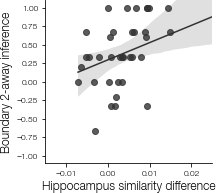

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
x = diff
y = (b2 - .5) * 2
sns.regplot(x=x, y=y, ax=ax, color=(.2, .2, .2))
ax.set(
    xlim=(-0.015, 0.025),
    ylim=(-1.1, 1.1),
    xlabel='Hippocampus similarity difference',
    ylabel='Boundary 2-away inference',
)
fig.savefig(os.path.join(fig_dir, 'hipr_b2.pdf'))

In [6]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

numpy     : 1.18.1
matplotlib: 3.4.3
seaborn   : 0.11.1
pingouin  : 0.4.0
tesser    : 0.1.0

